In [15]:
import json
import spacy

nlp = spacy.load("en_core_web_sm")


train_data = json.load(open("../data/train_text_features_matres.json"))
num_dict = {0: "before", 1: "after", 2: "equal", 3: "vague"}



In [74]:
np.mean([len(item['text'].replace('[CLS]', "").replace('[SEP]', "").strip().split()) for item in train_data])

83.70991161616162

In [16]:
nlp("said")[0].lemma_

'say'

In [68]:
from tqdm import tqdm

ht_freq_dict = {}
for item in tqdm(train_data):
    h = nlp(item['e1'])[0].lemma_
    t = nlp(item['e2'])[0].lemma_
    rs = [num_dict[l] for l in item['labels']]
    if (h, t) in ht_freq_dict:
        pass
    else:
        ht_freq_dict[(h, t)] = {"before":0, "after":0, "equal":0, "vague":0}
    for r in rs:
        ht_freq_dict[(h, t)][r] += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6336/6336 [01:12<00:00, 87.70it/s]


In [69]:
ht_prob_dict = {}
for (h, t), f_dict in ht_freq_dict.items():
    before_h_t = ht_freq_dict[(h, t)]["before"]
    before_t_h = ht_freq_dict.get((t, h), {"before":0})["before"]
    
    after_h_t = ht_freq_dict[(h, t)]["after"]
    after_t_h = ht_freq_dict.get((t, h), {"after":0})["after"]
    
    equal_h_t = ht_freq_dict[(h, t)]["equal"]
    equal_t_h = ht_freq_dict.get((t, h), {"equal":0})["equal"]
    
    sum_h_t = before_h_t + before_t_h + after_h_t + after_t_h + equal_h_t + equal_t_h
    
    if sum_h_t == 0:
        continue
    
    ht_prob_dict[(h, t)] = ({"before":0, "after":0, "equal":0}, sum_h_t)
    
    ht_prob_dict[(h, t)][0]["before"] = (before_h_t + after_t_h) / sum_h_t
    ht_prob_dict[(h, t)][0]["after"]  = (after_h_t + before_t_h) / sum_h_t
    ht_prob_dict[(h, t)][0]["equal"]  = (equal_h_t + equal_t_h) / sum_h_t

In [70]:
np.save("./ht_prob_dict", ht_prob_dict)

In [30]:
# check those "before" happens frequently:


sorted([(key, item) for key, item in ht_prob_dict.items() if item[1] > 2], key=lambda x:x[1][0]["before"], reverse=True)



[(('try', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 4)),
 (('hold', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 32)),
 (('make', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 35)),
 (('engage', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 4)),
 (('work', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 5)),
 (('put', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 5)),
 (('agree', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 26)),
 (('plan', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 12)),
 (('oppose', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 4)),
 (('buy', 'tell'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 3)),
 (('follow', 'say'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 7)),
 (('rise', 'close'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 6)),
 (('fall', 'rise'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 5)),
 (('face', 'seek'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 3)),
 (('say

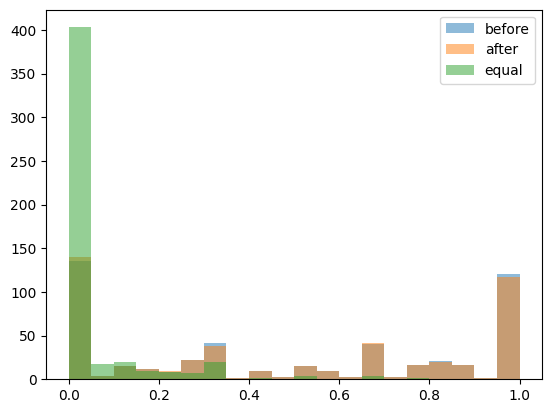

In [77]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist([item[0]["before"] for key, item in ht_prob_dict.items() if item[1] > 2], bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="before")
plt.hist([item[0]["after"] for key, item in ht_prob_dict.items() if item[1] > 2], bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="after")
plt.hist([item[0]["equal"] for key, item in ht_prob_dict.items() if item[1] > 2], bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="equal")
plt.legend()
plt.show()

# 2. narrative bias

In [39]:
train_features = json.load(open("../data/train_features_matres.json"))

In [42]:
from tqdm import tqdm

pos_list = []
for item in tqdm(train_features):
    rs = [num_dict[l] for l in item['labels']]
    for r in rs:
        pos_list.append(item['event_pos'] + [r])
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6336/6336 [00:00<00:00, 366907.50it/s]


In [53]:
# p(before |pos1 < pos2) v.s. p(after |pos1 < pos2)

# np.mean([ (p1 < p2 and r == "before")  for p1, p2, r in pos_list if r in ["before", "after"]])
np.mean([r == "before" for p1, p2, r in pos_list if p1 < p2]), np.mean([r == "after" for p1, p2, r in pos_list if p1 < p2])

(0.5096275252525253, 0.3226010101010101)

### proximity

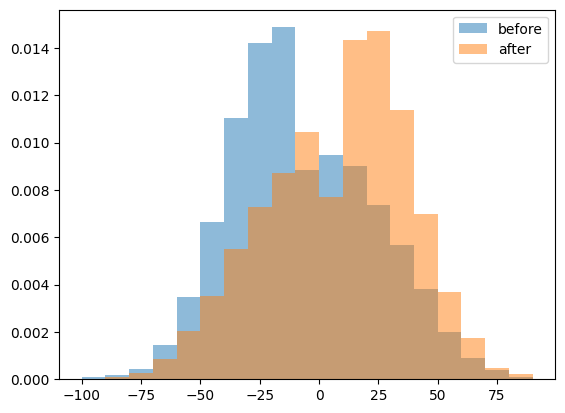

In [56]:
# proximity:

# plt.hist([p1 - p2 for p1, _, r, p2 in pos_relations if r == "during" or r == "while"], label="meanwhile", density=True, alpha=0.5, bins=range(-100, 100, 10))
plt.hist([p1 - p2 for p1, p2, r in pos_list if r == "before"] + [p2-p1 for p1, p2, r in pos_list if r == "after"], label="before", density=True, alpha=0.5, bins=range(-100, 100, 10))
plt.hist([p1 - p2 for p1, p2, r in pos_list if r == "after"]  + [p2-p1 for p1, p2, r in pos_list if r == "before"], label="after", density=True, alpha=0.5, bins=range(-100, 100, 10))
plt.legend()

plt.show()

# 3. Tense bias

In [59]:
train_data[0]['text'].replace('[CLS]', "").replace('[SEP]', "").strip()

'For his part, Fidel Castro is the ultimate political survivor. People have predicted his demise so many times, and the US has tried to hasten it on several occasions. Time and again, he endures.'

In [63]:
from tqdm import tqdm


tense_freq_dict = {}
for item in tqdm(train_data):
    text = item['text'].replace('[CLS]', "").replace('[SEP]', "").strip()
    parsed_text = nlp(text)
        
    for i in range(len(parsed_text)):
        if parsed_text[i].text == item['e1']:
            h = parsed_text[i].lemma_
            tense_h = parsed_text[i].tag_
        if parsed_text[i].text == item['e2']:
            t = parsed_text[i].lemma_
            tense_t = parsed_text[i].tag_
    
    rs = [num_dict[l] for l in item['labels']]
    if (tense_h, tense_t) in tense_freq_dict:
        pass
    else:
        tense_freq_dict[(tense_h, tense_t)] = {"before":0, "after":0, "equal":0, "vague":0}
    for r in rs:
        tense_freq_dict[(tense_h, tense_t)][r] += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6336/6336 [01:55<00:00, 54.97it/s]


In [65]:
tense_prob_dict = {}
for (h, t), f_dict in tense_freq_dict.items():
    before_h_t = tense_freq_dict[(h, t)]["before"]
    before_t_h = tense_freq_dict.get((t, h), {"before":0})["before"]
    
    after_h_t = tense_freq_dict[(h, t)]["after"]
    after_t_h = tense_freq_dict.get((t, h), {"after":0})["after"]
    
    equal_h_t = tense_freq_dict[(h, t)]["equal"]
    equal_t_h = tense_freq_dict.get((t, h), {"equal":0})["equal"]
    
    sum_h_t = before_h_t + before_t_h + after_h_t + after_t_h + equal_h_t + equal_t_h
    
    if sum_h_t == 0:
        continue
    
    tense_prob_dict[(h, t)] = ({"before":0, "after":0, "equal":0}, sum_h_t)
    
    tense_prob_dict[(h, t)][0]["before"] = (before_h_t + after_t_h) / sum_h_t
    tense_prob_dict[(h, t)][0]["after"]  = (after_h_t + before_t_h) / sum_h_t
    tense_prob_dict[(h, t)][0]["equal"]  = (equal_h_t + equal_t_h) / sum_h_t

In [67]:

sorted([(key, item) for key, item in tense_prob_dict.items() if item[1] > 2], key=lambda x:x[1][0]["before"], reverse=True)



[(('JJ', 'VB'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 3)),
 (('NN', 'VBZ'), ({'before': 1.0, 'after': 0.0, 'equal': 0.0}, 4)),
 (('NN', 'VBG'),
  ({'before': 0.8888888888888888, 'after': 0.1111111111111111, 'equal': 0.0},
   9)),
 (('VBN', 'JJ'),
  ({'before': 0.8333333333333334, 'after': 0.16666666666666666, 'equal': 0.0},
   6)),
 (('NN', 'VBD'),
  ({'before': 0.8235294117647058,
    'after': 0.11764705882352941,
    'equal': 0.058823529411764705},
   17)),
 (('NN', 'VB'), ({'before': 0.8, 'after': 0.0, 'equal': 0.2}, 5)),
 (('NNS', 'VBD'), ({'before': 0.8, 'after': 0.2, 'equal': 0.0}, 5)),
 (('VBN', 'VB'),
  ({'before': 0.7986577181208053,
    'after': 0.1610738255033557,
    'equal': 0.040268456375838924},
   149)),
 (('VBN', 'VBP'),
  ({'before': 0.7831325301204819,
    'after': 0.18072289156626506,
    'equal': 0.03614457831325301},
   83)),
 (('JJ', 'VBG'),
  ({'before': 0.7777777777777778, 'after': 0.2222222222222222, 'equal': 0.0},
   9)),
 (('JJ', 'VBP'), ({'before': 

In [71]:
np.save("./tense_prob_dict", tense_prob_dict)

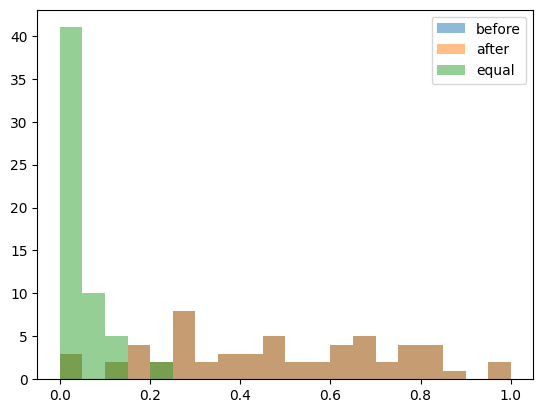

In [72]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist([item[0]["before"] for key, item in tense_prob_dict.items() if item[1] > 2], bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="before")
plt.hist([item[0]["after"] for key, item in tense_prob_dict.items() if item[1] > 2], bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="after")
plt.hist([item[0]["equal"] for key, item in tense_prob_dict.items() if item[1] > 2], bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="equal")
plt.legend()
plt.show()